In [9]:
from cartopy import crs as ccrs
from matplotlib import pyplot as plt
from cgeniepy.model import GenieModel
import pandas as pd

## observational sst data from Tabor et al. 2016

model = GenieModel("../model/muffin.u067bc.PO4Fe.SPIN", gemflag=['biogem','ecogem'])

sst = model.get_var("ocn_sur_temp").isel(time=-1)
npp = model.get_var("eco2D_Uptake_Fluxes_C").isel(time=-1)
## g C m-2 yr-1
npp = npp * 80.8 * 12 * 365 * 1E-3

sst.data.attrs['units'] = "°C"
sst.data.attrs['long_name'] = "Sea surface temperature"
npp.data.attrs['long_name'] = "Net primary production"

size = model.get_var("eco2D_Size_Mean").isel(time=-1)
size.data.attrs['units'] = "µm"
size.data.attrs['long_name'] = "Mean size of plankton"

lat = model.get_var("lat").data
sst_zonal_mean = sst.data.mean(dim="lon")
sst_zonal_sd = sst.data.std(dim="lon")
npp_zonal_mean = npp.data.mean(dim="lon")
npp_zonal_sd = npp.data.std(dim="lon")
size_zonal_mean = size.data.mean(dim="lon")
size_zonal_sd = model.get_var("eco2D_Size_Stdev").isel(time=-1).data.mean(dim="lon")

# sst_tabor = pd.read_excel("../data/Tabor_Maastrichtian_proxy.xlsx")
# sst_tabor = sst_tabor[sst_tabor['Type']!='Planktonic forams']
sst_zhang = pd.read_csv("../data/Zhang2019.csv")

/Users/yingrui/miniforge3/envs/env/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yingrui/miniforge3/envs/env/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


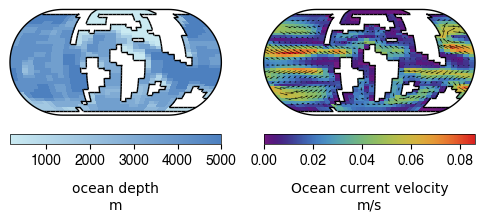

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from cgeniepy.plot import CommunityPalette
cmap = CommunityPalette("osmc_bluescale_r").colormap

# Assuming 'model' is predefined and has the necessary methods to get variables
phys_u = model.get_var("phys_u").isel(time=-1,zt=0)
phys_v = model.get_var("phys_v").isel(time=-1,zt=0)
lon = model.get_var("lon")
lat = model.get_var("lat")

# Create the figure and axis
fig, ax = plt.subplots(1,2,figsize=(6, 8), subplot_kw={'projection': ccrs.EckertIV()})

phys_uv = np.sqrt(phys_u.data**2 + phys_v.data**2)
phys_uv.attrs['long_name'] = "Ocean current velocity"
phys_uv.attrs['units'] = "m/s"
from cgeniepy.array import GriddedData
phys_uv = GriddedData(phys_uv, attrs=phys_uv.attrs).to_GriddedDataVis()
phys_uv.aes_dict['pcolormesh_kwargs']['cmap'] = CommunityPalette("tol_rainbow").colormap
phys_uv.plot(ax=ax[1], outline=True, colorbar=True)

# Plot the quiver plot
ax[1].quiver(lon, lat, phys_u.data, phys_v.data, transform=ccrs.PlateCarree(), regrid_shape=20)

grid_topo = model.get_var("grid_topo")
topo_plot = grid_topo.to_GriddedDataVis()
topo_plot.aes_dict['pcolormesh_kwargs']['cmap'] = cmap
topo_plot.plot(outline=True, colorbar=True, ax=ax[0])

## save the fig
plt.savefig("../output/cretaceous_base.png", bbox_inches="tight", dpi=300)

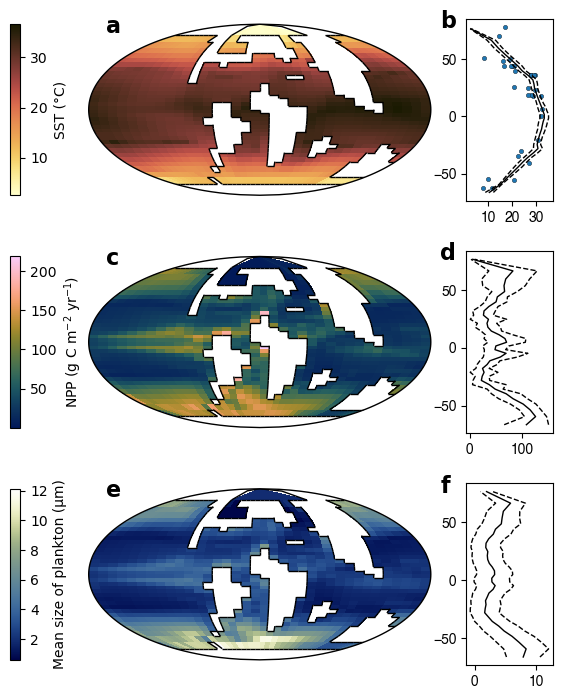

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean as cmo
import matplotlib as mpl

mpl.rcParams['pdf.fonttype']=42
## set font: Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# 1) Make the figure smaller by tightening figsize:
fig = plt.figure(figsize=(7, 9))  
# 2) Expand to 30 rows so each row-block is 10 units high:
spec = fig.add_gridspec(30, 18)

def new_axis_right(ax):
    divider = make_axes_locatable(ax)
    return divider.new_horizontal(size="30%", pad=1, axes_class=plt.Axes)

# --- First row: SST map + zonal plot ---
ax1 = fig.add_subplot(spec[ 0:10,  0:14], projection=ccrs.Mollweide())
ax2 = fig.add_subplot(spec[ 1:9,  15:19])
# --- Second row: NPP map + zonal plot ---
ax3 = fig.add_subplot(spec[10:20,  0:14], projection=ccrs.Mollweide())
ax4 = fig.add_subplot(spec[11:19, 15:19])
# --- Third row: NEW variable map + zonal plot ---
ax5 = fig.add_subplot(spec[20:30,  0:14], projection=ccrs.Mollweide())
ax6 = fig.add_subplot(spec[21:29, 15:19])

sst_vis = sst.to_GriddedDataVis()
npp_vis = npp.to_GriddedDataVis()
size_vis = size.to_GriddedDataVis()
from palettable.scientific.sequential import Davos_20, Imola_20, Batlow_20, LaJolla_20

sst_vis.aes_dict['pcolormesh_kwargs']['cmap'] = LaJolla_20.mpl_colormap
npp_vis.aes_dict['pcolormesh_kwargs']['cmap'] = Batlow_20.mpl_colormap
size_vis.aes_dict['pcolormesh_kwargs']['cmap'] = Davos_20.mpl_colormap

sst_plot = sst_vis.plot(ax=ax1, colorbar=False,outline=True)
npp_plot = npp_vis.plot(ax=ax3, colorbar=False,outline=True)
size_plot = size_vis.plot(ax=ax5, colorbar=False,outline=True)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("left", size="3%", axes_class=plt.Axes)
cbar_sst = plt.colorbar(sst_plot, cax=cax1, orientation='vertical')
cbar_sst.set_label("SST (°C)")

divider = make_axes_locatable(ax3)
cax2 = divider.append_axes("left", size="3%", axes_class=plt.Axes)
cbar_npp = plt.colorbar(npp_plot, cax=cax2, orientation='vertical')
cbar_npp.set_label(r"NPP (g C m$^{-2}$ yr$^{-1}$)")

divider = make_axes_locatable(ax5)
cax3 = divider.append_axes("left", size="3%", axes_class=plt.Axes)
cbar_size = plt.colorbar(size_plot, cax=cax3, orientation='vertical')
cbar_size.set_label("Mean size of plankton (µm)")

ax2.plot(sst_zonal_mean, lat, color="k", linewidth=1)
ax2.plot(sst_zonal_mean - sst_zonal_sd, lat, color="k", linewidth=1, linestyle="--")
ax2.plot(sst_zonal_mean + sst_zonal_sd, lat, color="k", linewidth=1, linestyle="--")
ax2.set_xticks([0, 10, 20, 30])

ax4.plot(npp_zonal_mean, lat, color="k", linewidth=1)
ax4.plot(npp_zonal_mean - npp_zonal_sd, lat, color="k", linewidth=1, linestyle="--")
ax4.plot(npp_zonal_mean + npp_zonal_sd, lat, color="k", linewidth=1, linestyle="--")

ax6.plot(size_zonal_mean, lat, color="k", linewidth=1)
ax6.plot(size_zonal_mean - size_zonal_sd, lat, color="k", linewidth=1, linestyle="--")
ax6.plot(size_zonal_mean + size_zonal_sd, lat, color="k", linewidth=1, linestyle="--")

import seaborn as sns
sns.scatterplot(data=sst_zhang, y="Paleolatitude", x="MAT", edgecolor = "black", ax=ax2, s=10)

ax2.set(xlabel=None)
ax2.set(ylabel=None)


## labeling the subplots
ax1.text(0.05, 0.95, "a", transform=ax1.transAxes, fontsize=16, fontweight="bold")
ax2.text(-0.3, 0.95, "b", transform=ax2.transAxes, fontsize=16, fontweight="bold")
ax3.text(0.05, 0.95, "c", transform=ax3.transAxes, fontsize=16, fontweight="bold")
ax4.text(-0.3, 0.95, "d", transform=ax4.transAxes, fontsize=16, fontweight="bold")
ax5.text(0.05, 0.95, "e", transform=ax5.transAxes, fontsize=16, fontweight="bold")
ax6.text(-0.3, 0.95, "f", transform=ax6.transAxes, fontsize=16, fontweight="bold")

## save figure
fig.savefig("../output/cretaceous_ocn.png", bbox_inches="tight", dpi=300)

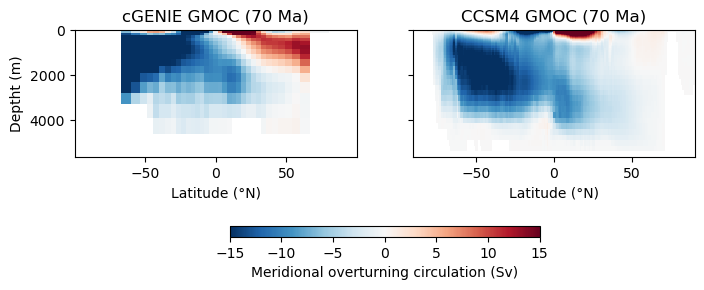

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3),sharey=True)

model.get_var("phys_opsi").isel(time=-1).data.plot(cmap='RdBu_r',vmin=-15,vmax=15, ax=axs[0], add_colorbar=False)

import xarray as xr
test = xr.open_dataset("../data/MOC_all_simus.nc")
p = test['MOC_Global_Maas4xCO2'].isel(moc_comp=0).plot(ax=axs[1], vmax=15, vmin=-15, cmap='RdBu_r', add_colorbar=False )
## reverse y axis
axs[1].set_ylim(axs[1].get_ylim()[::-1])

axs[0].set_title("cGENIE GMOC (70 Ma)")
axs[1].set_title("CCSM4 GMOC (70 Ma)")
axs[0].set_ylabel("Deptht (m)")
axs[1].set_ylabel("")
axs[0].set_xlabel("Latitude (°N)")
axs[1].set_xlabel("Latitude (°N)")

## add colorbar
cbar = fig.colorbar(p, ax=axs, orientation='horizontal', pad=0.3, aspect=30, shrink=0.5)
cbar.set_label("Meridional overturning circulation (Sv)")
fig.savefig("../output/cretaceous_gmoc.png", bbox_inches="tight", dpi=300)

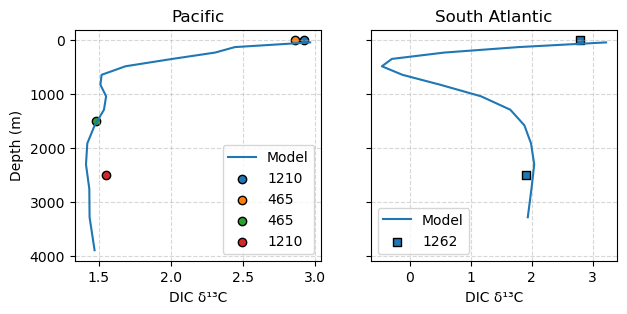

In [13]:
import matplotlib.pyplot as plt

# grab the two profiles at the last time-step
p1 = model.get_var("ocn_DIC_13C") \
          .sel(lon=-175, lat=15, method='nearest') \
          .isel(time=-1)
p2 = model.get_var("ocn_DIC_13C") \
          .sel(lon=0, lat=-30, method='nearest') \
          .isel(time=-1)

# pull out the depth coordinate (replace 'depth' with your actual depth coord name)
depth1 = p1.data.zt
depth2 = p2.data.zt

# create a figure with two subplots side by side, sharing y-axis (depth)
fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

# first subplot (Site A)
ax = axes[0]
ax.plot(p1.data.values, depth1, label='Model')
ax.scatter(2.92, 0, marker='o', edgecolor='k', label='1210')
ax.scatter(2.86, 0, marker='o', edgecolor='k', label='465')
ax.scatter(1.48, 1500, marker='o', edgecolor='k', label='465')
ax.scatter(1.55, 2500, marker='o', edgecolor='k', label='1210')
ax.set_title('Pacific')
ax.set_xlabel('DIC δ¹³C')
ax.set_ylabel('Depth (m)')
ax.invert_yaxis()      # depth increases downward
ax.legend()
ax.grid(linestyle='--', alpha=0.5)

# second subplot (Site B)
ax = axes[1]
ax.plot(p2.data.values, depth2, label='Model')
ax.scatter([2.8, 1.9], [0, 2500],
           marker='s', edgecolor='k', label='1262')
ax.set_title('South Atlantic')
ax.set_xlabel('DIC δ¹³C')
ax.legend()
ax.grid(linestyle='--', alpha=0.5)
# save to fig
plt.savefig("../output/cretaceous_d13c.png", bbox_inches="tight", dpi=300)

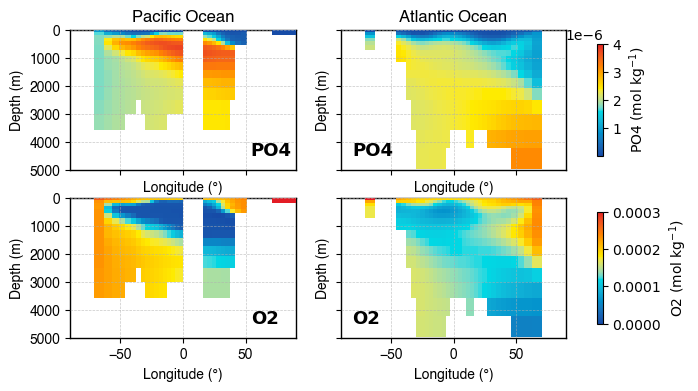

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(8, 4), sharex=True, sharey=True)
from tkinter import font
from cgeniepy.plot import CommunityPalette
cmap_po4 = CommunityPalette("my_rainbow2").colormap
cmap_o2 = CommunityPalette("my_rainbow2").colormap
axs[0,0].set_ylim(5000,0)
p1 = model.get_var("ocn_PO4").isel(time=-1).sel(lon=-5).plot(ax=axs[0,0], colorbar=False,cmap=cmap_po4, vmax=4E-6)
model.get_var("ocn_O2").isel(time=-1).sel(lon=-5).plot(ax=axs[1,0], colorbar=False,cmap=cmap_o2, vmax=3E-4)
model.get_var("ocn_PO4").isel(time=-1).sel(lon=175).plot(ax=axs[0,1], colorbar=False, cmap=cmap_po4, vmax=4E-6, vmin=0)
p2 = model.get_var("ocn_O2").isel(time=-1).sel(lon=175).plot(ax=axs[1,1], colorbar=False, cmap=cmap_o2, vmax=3E-4, vmin=0)

for ax in axs.flat:
    ax.set_xlabel("Longitude (°)")
    ax.set_ylabel("Depth (m)")

axs[0,0].text(0.8, 0.1, "PO4", transform=axs[0,0].transAxes, fontsize=13, fontweight="bold")
axs[1,0].text(0.8, 0.1, "O2", transform=axs[1,0].transAxes, fontsize=13, fontweight="bold")
axs[0,1].text(0.05, 0.1, "PO4", transform=axs[0,1].transAxes, fontsize=13, fontweight="bold")
axs[1,1].text(0.05, 0.1, "O2", transform=axs[1,1].transAxes, fontsize=13, fontweight="bold")

## add colorbar
c1 = fig.colorbar(p1, ax=axs[0,:], orientation='vertical', pad=0.05, shrink=0.8)
c2 = fig.colorbar(p2, ax=axs[1,:], orientation='vertical', pad=0.05, shrink=0.8)
c1.set_label("PO4 (mol kg$^{-1}$)")
c2.set_label("O2 (mol kg$^{-1}$)")

axs[0,0].set_title("Pacific Ocean", fontfamily='Helvetica')
axs[0,1].set_title("Atlantic Ocean", fontfamily='Helvetica')
# save to fig
plt.savefig("../output/cretaceous_bgc.png", bbox_inches="tight", dpi=300)